In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda'

# Load the Data and create Datasets

In [3]:
def display_random_samples(processed_images, num_samples=16):
    """
    Randomly selects and displays a specified number of samples from the processed images.
    
    Parameters:
    - processed_images: A list of tuples, each containing (image, class),
                        where image is a numpy array of shape (128, 128).
    - num_samples: The number of samples to display. Default is 16.
    """
    # Ensure there are enough images to sample
    if len(processed_images) < num_samples:
        print(f"Requested {num_samples} samples, but only {len(processed_images)} are available.")
        num_samples = len(processed_images)
    
    # Randomly select samples
    selected_samples = random.sample(processed_images, num_samples)
    
    # Set up the plot
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))  # Adjust the size as needed
    fig.suptitle('Randomly Selected Samples')
    
    # Flatten axes array for easy indexing
    axes = axes.flatten()
    
    for i, (image, image_class) in enumerate(selected_samples):
        axes[i].imshow(image, cmap='gray', vmin=0, vmax=1)  # Ensure correct color mapping and normalization
        subtext = "cat" if image_class == 1.0 else "dog"
        axes[i].title.set_text(subtext)
        axes[i].axis('off')  # Hide axes for better visualization
    plt.tight_layout()
    plt.show()

In [4]:
IMAGE_DIR = "../data"

In [5]:
image_path = Path(IMAGE_DIR)

In [6]:
path_classes = [ d for d in image_path.iterdir() if d.is_dir() and not d.name.startswith('.')]

In [7]:
samples = []
for path in path_classes:
    files = list(path.glob('*.png'))
    for file in files:
        samples.append((file , 1.0 if path.name == "cat" else 0.0))

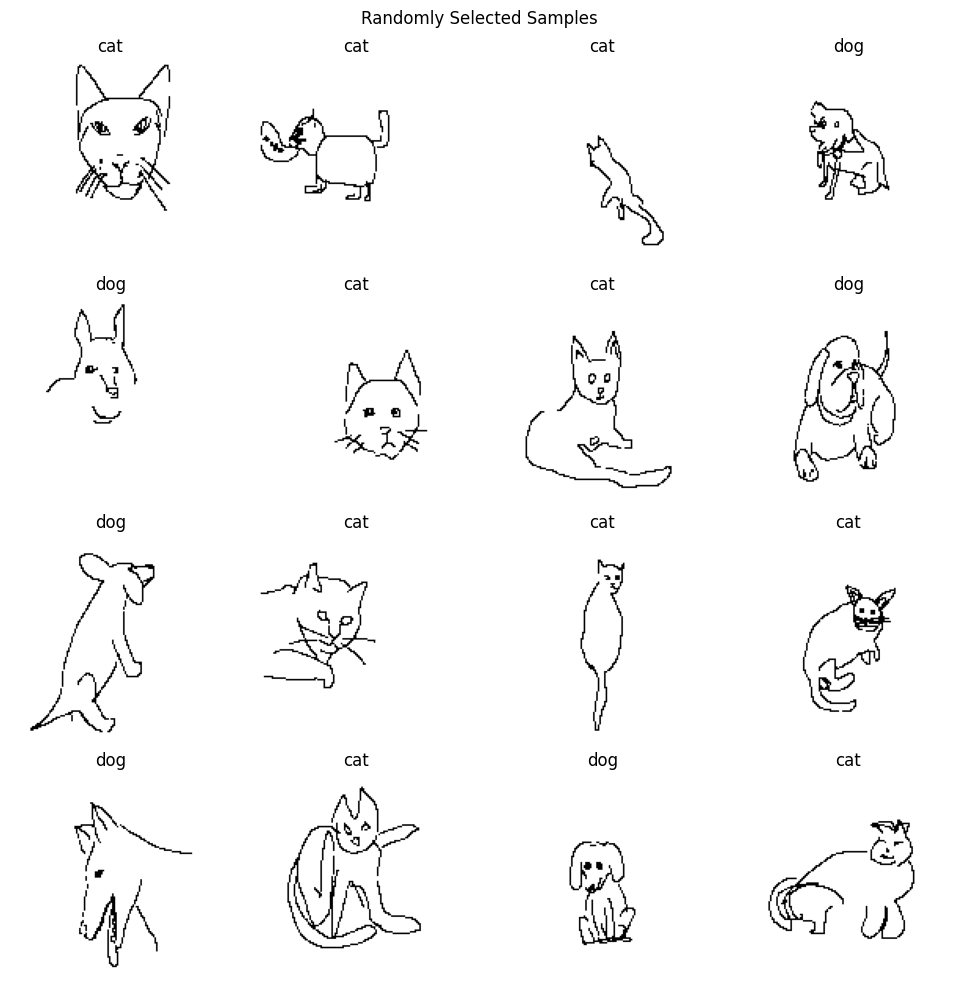

In [8]:
processed_images = []
for path, image_class in samples:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    _ , image = cv2.threshold(image, 127, 1, cv2.THRESH_BINARY)
    image = image.astype(np.float32)
    processed_images.append((image, image_class))
display_random_samples(processed_images)

# Create a Pytorch Dataset

In [9]:
class SketchDataset(Dataset):
    def __init__(self, processed_images):
        self.processed_images = processed_images
    def __len__(self):
        return len(self.processed_images)
    def __getitem__(self,idx):
        image, label = self.processed_images[idx]
        image = image[np.newaxis, :, :]
        image_tensor = torch.tensor(image, dtype=torch.float32)
        label_tensor = torch.tensor([label], dtype=torch.float32)
        return image_tensor, label_tensor

In [10]:
total_samples = len(processed_images)

train_size = int(total_samples * 0.8)
test_size = total_samples - train_size

train_dataset, test_dataset = random_split(SketchDataset(processed_images), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Model

In [11]:
class EnhancedCNNMoreDropout(nn.Module):
    def __init__(self):
        super(EnhancedCNNMoreDropout, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.4)

        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(x)))))))
        x = self.dropout2(x)

        x = x.view(-1, 64 * 32 * 32)

        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [12]:
model = EnhancedCNNMoreDropout()
model.to(device)

EnhancedCNNMoreDropout(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=65536, out_features=512, 

In [13]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [14]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

In [15]:
EPOCHS = 100
MODEL_PATH = 'classifier_nn_weights_100_LR0_000001.pth'

train_losses = []
test_losses = []

train_accs = []
test_accs = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_acc = 0

    total_test_loss = 0
    total_test_acc = 0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_logits = model(X_batch)
        y_pred = torch.round(torch.sigmoid(y_logits))
        loss = loss_fn(y_logits, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_fn(y_batch, y_pred)

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    avg_acc = total_acc / len(train_loader)
    train_accs.append(avg_acc)
    model.eval()

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            test_logits = model(X_batch)
            test_y_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_batch)

            total_test_loss += test_loss.item()
            total_test_acc += accuracy_fn(y_batch, test_y_pred)
            
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    avg_test_acc = total_test_acc / len(test_loader)
    test_accs.append(avg_test_acc)
    if (epoch % 10 == 0) or (epoch == EPOCHS-1):
        print(f"Epoch {epoch} | Average Loss: {avg_loss:.5f} - Average Acc: {avg_acc:.2f}% | Average Test Loss: {avg_test_loss:.5f} - Average Test Acc: {avg_test_acc:.2f}%")

torch.save(model.state_dict(),MODEL_PATH)

Epoch 0 | Average Loss: 0.70693 - Average Acc: 51.78% | Average Test Loss: 0.69112 - Average Test Acc: 55.37%
Epoch 10 | Average Loss: 0.62647 - Average Acc: 63.95% | Average Test Loss: 0.68026 - Average Test Acc: 55.85%
Epoch 20 | Average Loss: 0.58582 - Average Acc: 69.65% | Average Test Loss: 0.67508 - Average Test Acc: 57.72%
Epoch 30 | Average Loss: 0.55993 - Average Acc: 71.71% | Average Test Loss: 0.67808 - Average Test Acc: 59.45%
Epoch 40 | Average Loss: 0.51570 - Average Acc: 76.04% | Average Test Loss: 0.67193 - Average Test Acc: 60.40%
Epoch 50 | Average Loss: 0.46997 - Average Acc: 79.88% | Average Test Loss: 0.67355 - Average Test Acc: 62.28%
Epoch 60 | Average Loss: 0.44713 - Average Acc: 82.40% | Average Test Loss: 0.67150 - Average Test Acc: 61.18%
Epoch 70 | Average Loss: 0.42043 - Average Acc: 84.08% | Average Test Loss: 0.67175 - Average Test Acc: 63.07%
Epoch 80 | Average Loss: 0.40205 - Average Acc: 84.24% | Average Test Loss: 0.67335 - Average Test Acc: 63.38%
Ep

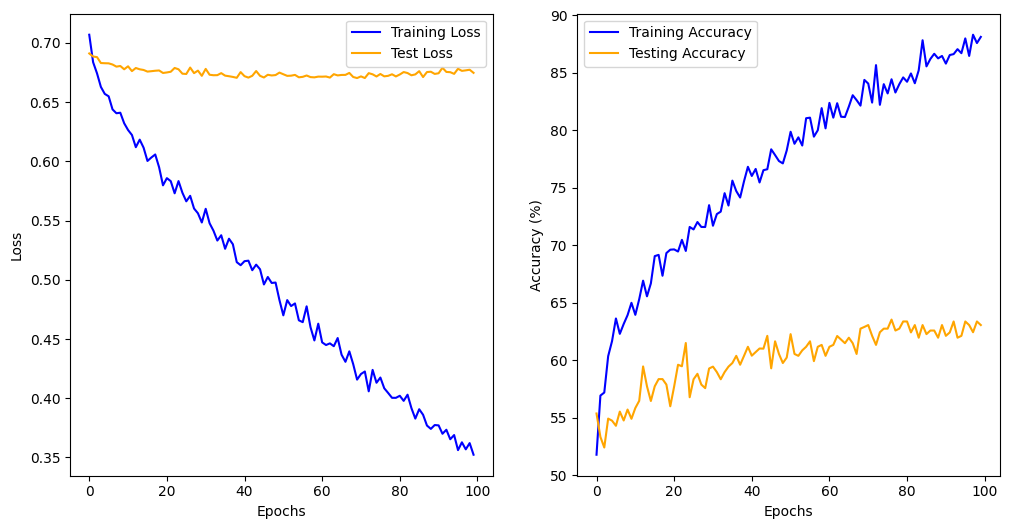

In [16]:
epochs = range(EPOCHS)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(epochs, train_losses, color = 'blue', label = "Training Loss")
ax1.plot(epochs, test_losses, color = 'orange', label = "Test Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(epochs, train_accs, color = 'blue', label = "Training Accuracy")
ax2.plot(epochs, test_accs, color = 'orange', label = "Testing Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()